In [1]:
from FEnicS_base import *
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import VectorFunctionSpace
from mpi4py import MPI
import numpy as np
import ufl
import matplotlib.pyplot as plt

import jsonpickle as jp
import shutil
import re
import inspect
from tqdm import tqdm

In [2]:
domain = mesh.create_interval(nx=100, comm=MPI.COMM_WORLD, points=[0, 1])
domain = mesh.create_unit_square(
    MPI.COMM_WORLD,
    10,
    10,
    cell_type=mesh.CellType.quadrilateral,
)
element = ufl.FiniteElement(family='CG', cell=domain.ufl_cell(), degree=1)
element2 = ufl.VectorElement(family='CG', cell=domain.ufl_cell(), degree=1)
space = FunctionSpace(domain, element=ufl.MixedElement(element,element2))
sub1 = space.sub(0).collapse()[0]
sub2 = space.sub(1).collapse()[0]

x = SpatialCoordinate(space)[0]
y = SpatialCoordinate(space)[1]
set_connectivity(domain)

ds = Measure("ds", domain=domain)
norm = FacetNormal(domain)

u, g = Function(space), Function(space)
v = TestFunction(space)

f = Constant(space, 2)

F = (grad(u)|dot|grad(v)) * dx - (f*v) * dx
# F -= (grad(u)|dot|norm) * v * ds

bcs = [
    DirichletBC(
        space=space,
        form=Constant(space, 1),
        combined_marker=lambda x: np.isclose(x[0], 0)
    ),
    DirichletBC(
        space=space,
        form=Constant(space, 1),
        combined_marker=lambda x: np.isclose(x[0], 1)
    )
]
problem = NonlinearProblem(
    u=u, F=F, bcs=bcs, petsc_options={
        "ksp_type": "preonly", "pc_type": "lu"
    }
)

<AxesSubplot:>

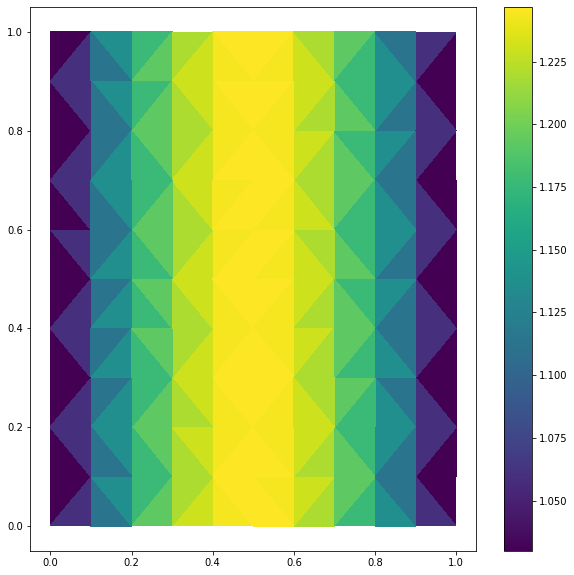

In [3]:
problem.solve()
func_plot2D(Function(space, u,'base'))